# Ch-5: Losses

this note book includes excercise of ch-5 of Understanding of Deep Leanrning book


Part 1: parameterising regression model for NLL

- change prespective#:
    - deterministic model: given an input x, the model predict y = f(x, theta), where `f` is a model parametrized by theta --> training goal; predicted y should be close to the training y values.
        - what is the advantage of this?
            - first, it captures unmodeled effects (systematic but missing): when we develop a predictive model, we usually don't have all possible input variables that influence the observed output variable; these effects end up in the error prediction error 
            - second, there could be measurement errors in the output variable, measurement error in real world data; irreducible model uncertainty
    - probabilistic, conditional probability: given an input x, the model predict p(y|x),; training goal; the training y values should have high probability, p(y|x)
        - how do you achiev this?
            - how can we adapt f to compute `p(y|x)`?; fist we choose a prametric distribution which is defined on the output domain, y,  = p(y|f(x, theta)); then using f learn theta; 
            - how do you choose the parameteric distribution? based on the possible values of y, i.e, the domain of y.  
            - for a countinuous output, $ y \in \mathbb{R}$, we might chose normal distribution, which is defined/parametrized by mean and variance
                - $ p(y|x) = p(y|f(x, theta)) = Normal_y ({\mu, \sigma^2}) $, and we train f to predict mean (always) and variance (sometimes could be taken as constant, else used as uncertainty metric)
                    - $ \mu  = f_1(x, theta) $
                    - $ \sigma ^2  = f_2(x, theta) $
                - during inference use sample from the distribution; $y_i = mean + \sqrt(var) * \epsilon, \epsilon \in Norm_y(\mu, \sigma)$
            - For binary output, $ y \in \{ 0, 1\}$ --> Bernoulli distribution, parameterized by $\lambda$
                - contraint,  $0 \le \lambda \le 1$
                - $p(y| \lambda) = p(y|sig(f(x, theta))); how do you train it?$p(y| \lambda) = \lambda \ if \  y=1, \ 1-\lambda \  other \  wise$
            - For categorical multiple output --> categorical distribution
                -  $p(y| \lambda) = p(y|softmax(f(x, theta))) $


## 1. Negative Log Likelihood (NLL) for regression

### dataset

In [331]:
from tqdm import tqdm 
from collections import defaultdict
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

import matplotlib.cm as cm
import matplotlib.colors as colors

%matplotlib widget
plt.close('all')

Text(0.5, 1.0, 'Training data distribution')

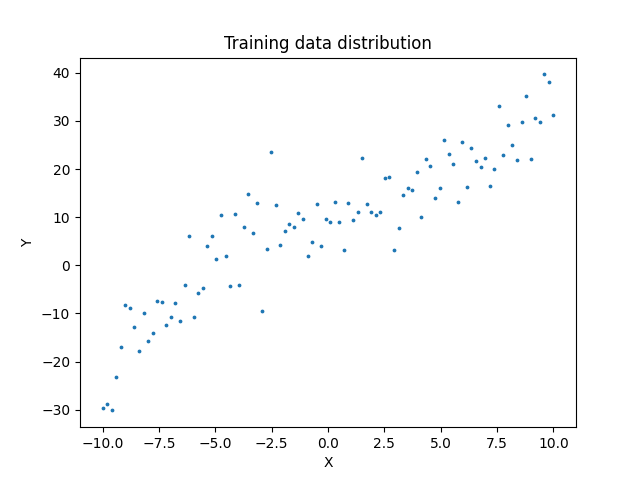

In [332]:
N = 100
X = torch.linspace(-10, 10, N).view(-1, 1)

# create a toy equation
Y = 10 + X - .05 * X ** 2 + 0.02 * X ** 3 + 5 * torch.randn(N, 1)

# visualise data
fig = plt.figure()
plt.scatter(X, Y, s=3)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Training data distribution')

## Define mean and var model

In [333]:
class MeanModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.layers = nn.ModuleList([
            nn.Linear(1, 8),
            nn.SiLU(),
            nn.Linear(8, 16,),
            nn.SiLU(),
            nn.Linear(16, 32),
            nn.SiLU(),
            nn.Linear(32, 8,),
            nn.SiLU(),
            nn.Linear(8, 1)
        ])

        self.act = nn.SiLU()

    def forward(self, x):

        for T in self.layers:
            x  = T(x)
        
        return x

class VarModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.layers = nn.ModuleList([
            nn.Linear(1, 8),
            nn.SiLU(),
            nn.Linear(8, 16,),
            nn.SiLU(),
            nn.Linear(16, 32),
            nn.SiLU(),
            nn.Linear(32, 8,),
            nn.SiLU(),
            nn.Linear(8, 1)
        ])

        self.act = nn.SiLU()

    def forward(self, x):

        for T in self.layers:
            x  = T(x)
        
        # variance has to be positive --> square it for similiciy; other transformation could be used
        return x ** 2

class ProbaRegression(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

        self.mean_estimator = MeanModel()
        self.var_estimator = VarModel()

    def forward(self, x):
        mu = self.mean_estimator(x)
        var = self.var_estimator(x)

        return mu, var

class NLL(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
    
    def forward(self, mu, var, y_true):
        
        nll_norm = self.nll_normalization(var) 
        nll_quad = self.nll_quadratic(mu, var, y_true)
        nll = -(nll_norm - nll_quad)

        return nll, nll_norm, nll_quad
    
    def nll_normalization(self, var):
        return torch.sum(torch.log(1/ torch.sqrt(2 * torch.pi * var)))

    def nll_quadratic(self, mu, var, y_true):
        squared_error = (y_true - mu) ** 2

        return torch.sum(squared_error / (2 * var))



In [334]:
def train(model, epochs, optimizer, criterion):
    info  = defaultdict(list)
    for e in tqdm(range(epochs), desc='training'):

        mu, var = model(X)

        nll, nll_norm, nll_quad = criterion(mu, var, Y)

        # compute gradient: dloss/dparams
        nll.backward()
        
        # update params
        optimizer.step()
        # clear gradients
        optimizer.zero_grad()

        info['epoch'].append(e)
        info['loss'].append(nll.item())

        # if e % 100:
        #     print(f"nll normalisation = {nll_norm}, nll quad = {nll_quad}")

        

    info = {k: torch.tensor(v).detach() for k, v in info.items()}

    return info

def plot_loss(info, title='Loss profile', label='loss', ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1)

    ax.plot(info['loss'], label=label)
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.set_title(title)

In [335]:
epochs = 1_000

model = ProbaRegression()
optim = torch.optim.AdamW(model.parameters(), lr=1e-3)
cost = NLL()

info = train(model, epochs, optim, cost)

training: 100%|██████████| 1000/1000 [00:01<00:00, 502.57it/s]


In [336]:
info['loss'].min(), info['loss'].max()

(tensor(631.8354), tensor(796908.0625))

Text(0.5, 0, 'Loss')

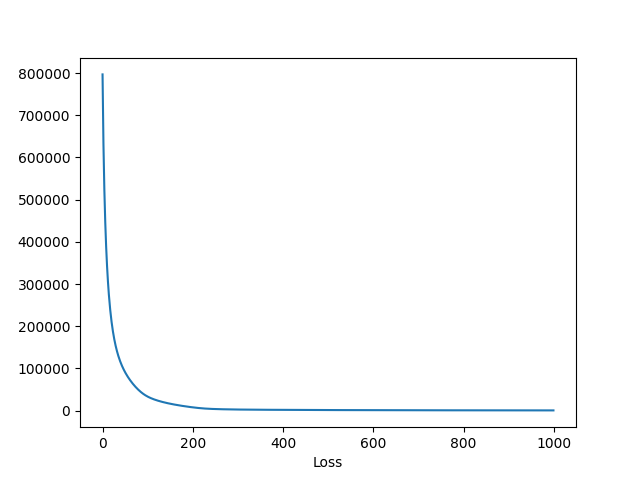

In [337]:
fig, ax = plt.subplots(1, 1)
# plot_loss(info, ax=ax)
ax.plot(info['loss'][:])
ax.set_xlabel('X')
ax.set_xlabel('Loss')

## learned p(y|x) visualisation

- visualisation of the learned p(y|x) distributions for differnt values of x

In [338]:
def p_y_given_x(mu, var, y):

    norm_const = 1/ torch.sqrt(2 * torch.pi * var)
    quad_term = (y - mu) ** 2 / (2 * var)

    p = norm_const * torch.exp(-quad_term)

    return p

def get_range(y):
    y_min, y_max = torch.abs(y.min()), torch.abs(y.max())
    y_range = torch.linspace(y_min - 2 * y_min, y_max + 2*y_max, 100) # make range bigger

    return y_range


Text(0.5, 0, 'p(y|x)')

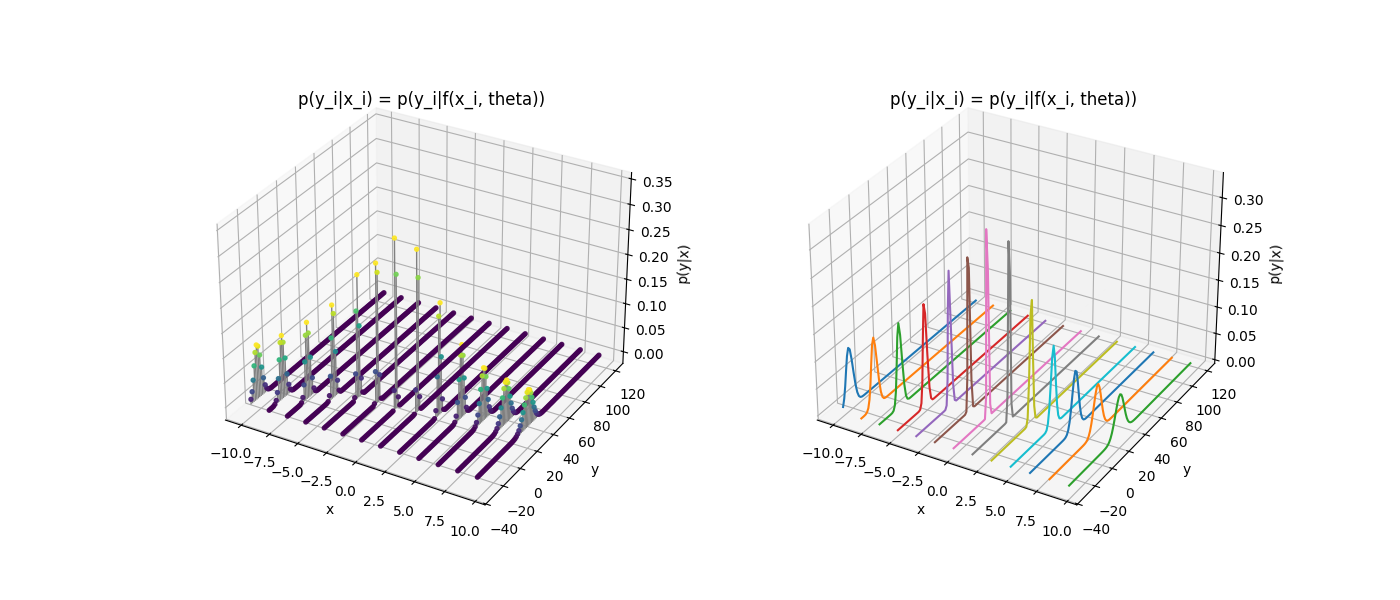

In [339]:
# this is the possible values of y 
y_min, y_max = Y.min(), Y.max()
y_range = get_range(Y)

fig = plt.figure(figsize=(14, 6))
# plot loss profile for fixed values of a0, intercept
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')
ax1.set_title('p(y_i|x_i) = p(y_i|f(x_i, theta))', y=0.99)
ax2.set_title('p(y_i|x_i) = p(y_i|f(x_i, theta))', y=0.99)

ks = list(range(len(X)))[::8]
for k in ks:

    x = X[k, :].view(-1, 1)

    mu, var = model(x)
    z = p_y_given_x(mu, var, y_range).squeeze()

    x_rep = x.repeat(1, len(y_range)).squeeze()

    x_np = x_rep.detach().numpy()
    y_np = y_range.detach().numpy()
    z_np = z.detach().numpy()

    cmap = cm.viridis
    norm = colors.Normalize(vmin=0.0, vmax=z_np.max().item())

    # ---- stems (neutral color) ----
    markerline, stemlines, baseline = ax1.stem(
        x_np, y_np, z_np,
        basefmt=" ",
    )

    stemlines.set_linewidth(1.0)
    stemlines.set_color("gray")
    markerline.set_visible(False)
    baseline.set_visible(False)

    # ---- colored points ----
    ax1.scatter(
        x_np,
        y_np,
        z_np,
        c=z_np,
        cmap="viridis",
        s=8,
        alpha=0.9,
        depthshade=False,
    )

    # line plots
    ax2.plot(x_np, y_np, z_np)

ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_zlabel('p(y|x)')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_zlabel('p(y|x)')




it is great that the prob distribution p(y|x_i) is different for differnt values of x

the width of the distribution shows uncertainty of prediction and there is high uncertainty for low and high x values, i.e at the extreme points

## sample from the distribution


Output is now parameterized as p(y|x) -- y_i ~ p(y_i | mu, var); where mu and var are learned by a model


sampling from a distibution, $ y_i \sim  Norm_y(mu, var) $ can be parametrized as

$$ y_i = mu + sqrt(var) * eps, \ eps \sim Norm(0, 1)$$

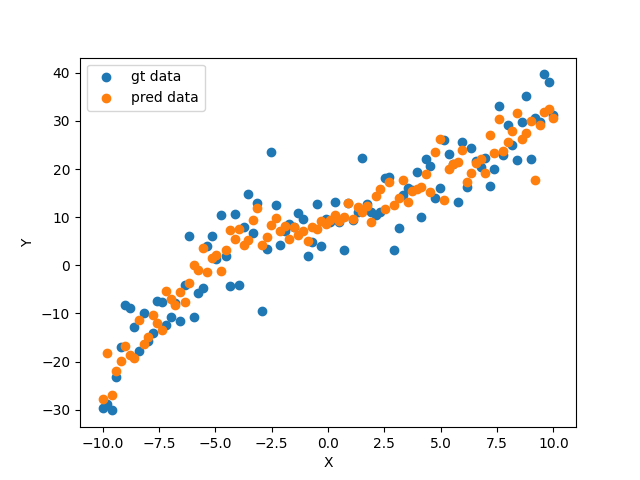

In [340]:
# get prob distribution parameters
mu, var = model(X)

# sample from the distribution
Y_pred = mu + torch.sqrt(var) * torch.randn_like(var)
Y_pred = Y_pred.detach().numpy()

fig, ax = plt.subplots(1, 1)
plt.scatter(X, Y, label='gt data')
plt.scatter(X, Y_pred, label='pred data')

plt.xlabel('X')
plt.ylabel('Y')
plt.legend()


## Binary cross entropy loss profile

In [341]:
from tqdm import tqdm 
from collections import defaultdict
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

import matplotlib.cm as cm
import matplotlib.colors as colors
import plotly.express as ex

%matplotlib widget
# plt.close('all')

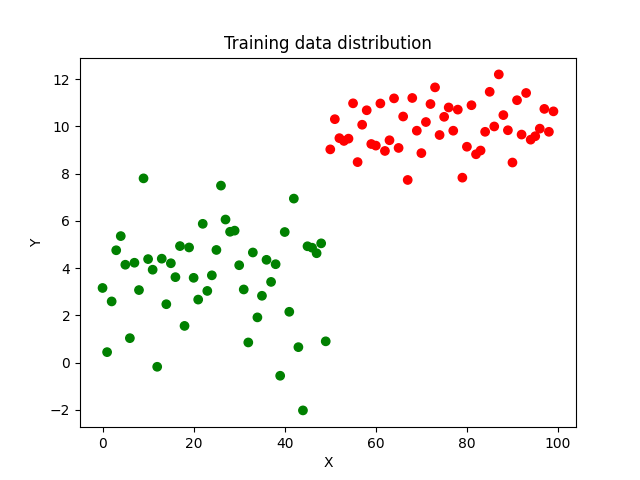

In [342]:
N = 100
X = torch.stack([3 + 2 * torch.randn(N//2, 1), 10 + torch.randn(N//2, 1)], dim=0)
Y = torch.repeat_interleave(torch.tensor([0, 1]), repeats=N//2)

# visualise data
fig = plt.figure()
plt.scatter(range(N), X, color=['g' if y.item() == 0 else 'r' for y in Y])
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Training data distribution')
plt.show()
# plt.close()

In [343]:
def nll_binary_class(model: dict, X: torch.Tensor, Y: torch.Tensor, eps=1e-8):
    """" this assumes the model has two params

    z = f(X, phi)= a0 + a1 * X
    
    For NLL, binary classification is parameterized by lamda

    lamda = sigmoid(z), since it has to between 0 and 1 (inclusive)

    p(y|lamda) = {lamda, if y=1, else 1-lamda}
    """
    
    z = model['a0'] + model['a1'] * X
    lamda = torch.sigmoid(z)
    pos_class_nll_term = -1 * torch.sum(Y * torch.log(lamda + eps ))
    neg_class_nll_term = -1 * torch.sum((1-Y) * torch.log(1 - lamda + eps))

    nll = pos_class_nll_term + neg_class_nll_term

    return nll

     

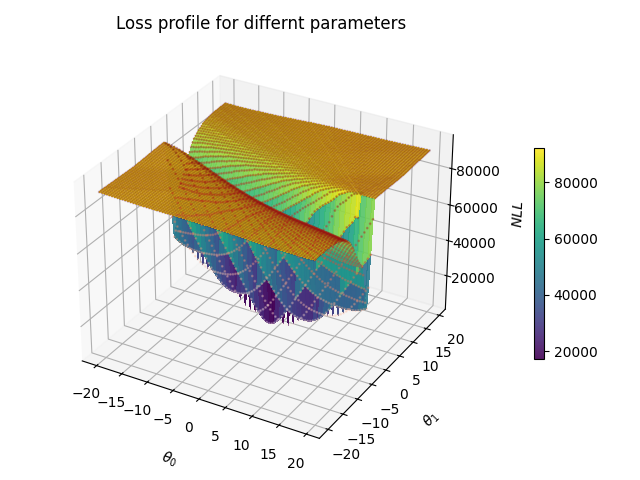

In [374]:
a0, a1 = torch.meshgrid(torch.arange(-20, 20, 0.5), torch.arange(-20.0, 20, 0.5), indexing='ij')

nll = torch.zeros_like(a0)
rows, cols = a0.shape

for r in range(rows):
    for c in range(cols):
        
        model = {'a0': a0[r,c], 'a1':a1[r, c]}
        nll[r, c] = nll_binary_class(model, X, Y)

# smooth nll
# w = 3
# kernel = torch.ones(1, 1, w, w) / w*w

# nll_new = nn.functional.conv2d(
#     nll.unsqueeze(0).unsqueeze(0), 
#     kernel, 
#     padding='same')

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

# surf = ax.plot_surface(a0, a1, nll, cmap='viridis', shade=False, alpha=1.0)
surf = ax.plot_surface(
    a0, a1, nll.squeeze(),
    cmap='viridis',
    linewidth=1,
    antialiased=False,
    alpha=0.9,
    shade=False
)# Add a color bar which maps values to colors.
scatter = ax.scatter(
    a0, a1, nll.squeeze(),
    cmap='Reds', s=1, alpha=0.3,
    c=nll
)
fig.colorbar(surf, shrink=0.5, aspect=20, pad=0.1)
ax.set_xlabel(r'$\theta_0$', labelpad=10)
ax.set_ylabel(r'$\theta_1$', labelpad=10)
ax.set_zlabel('$NLL$', labelpad=10)
ax.set_title('Loss profile for differnt parameters', pad=10)
plt.tight_layout()

## plotly version

In [372]:
import plotly.graph_objects as go

fig = go.Figure(
    data=[
        go.Surface(
            x=a0,
            y=a1,
            z=nll,
            colorscale='Viridis'
        ),

        go.Scatter3d(
        x=a0.flatten(),
        y=a1.flatten(),
        z=nll.flatten(),
        mode='markers',      # markers only
        marker=dict(
            size=2,
            color=nll.flatten(),          # color by z value
            colorscale='Reds',
            opacity=0.5
        )
    )

    ]
)

fig.update_layout(
    scene=dict(
        xaxis_title=r'theta_0',
        yaxis_title=r'theta_1',
        zaxis_title='NLL',
    ),
    margin=dict(l=0, r=0, b=0, t=0)
)

fig.show()


Great to see that NLL is convex.

Plotly has better 3d surface interpolation than matplotlib